In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.models import resnet18
from torchvision import transforms
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset,TensorDataset,DataLoader,random_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from d2l import torch as d2l
import random
import os
import torch.nn.functional as F
from torch.autograd import grad
import torch.nn.init as init
d2l.use_svg_display()

import math

['2C_battery-1', '2C_battery-2', '2C_battery-3', '2C_battery-4', '2C_battery-5', '2C_battery-6', '2C_battery-7', '2C_battery-8']


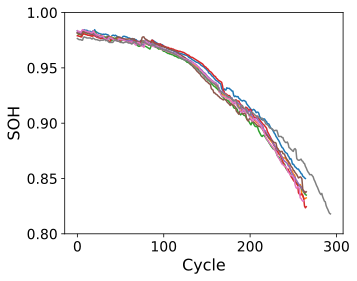

In [5]:
Batch_list=['Batch-1','Batch-2','Batch-3','Batch-4','Batch-5','Batch-6']
def choose_batch(Batch_name):
    Battery_list=[]
    dir='../source_data/XJTU_data/'+Batch_name
    for name in os.listdir(dir):
        Battery_list.append(name.strip('.mat'))
    source_data_path='../source_data/XJTU_data/'+Batch_name+'/'
    target_data_path='../data/XJTU_data/'+Batch_name+'/'+'all/'
    return Battery_list,source_data_path,target_data_path
Battery_list,source_data_path,target_data_path=choose_batch(Batch_list[0])
print(Battery_list)
def smooth_data(sequence, window_size):
    """数据平滑"""
    if window_size < 1:
        raise ValueError("窗口大小必须大于等于1")
    # 初始化平滑后的数据列表
    smoothed_sequence = []
    # 计算窗口内的平均值
    for i in range(len(sequence)):
        # 计算窗口的起始和结束索引
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        # 计算窗口内的数据平均值
        window_average = sum(sequence[start_index:end_index]) / (end_index - start_index)
        # 将平均值添加到平滑后的数据列表中
        smoothed_sequence.append(window_average)
    return smoothed_sequence
def add_row_index_to_array(arr):
    """
    在输入数组的每一行的第一个元素加上行号，并扩展数组维度。
    
    参数:
    arr (np.ndarray): 形状为 (n, 6) 的输入数组。
    
    返回:
    np.ndarray: 形状为 (n, 7) 的数组。
    """
    # 检查输入数组形状是否为 (n, 6)
    if arr.shape[1] != 10:
        raise ValueError("输入数组必须是形状为 (n, 10) 的数组。")

    # 创建一个新数组，其形状为 (n, 7)，初始化为输入数组
    new_arr = np.zeros((arr.shape[0], 11))
    new_arr[:, 1:] = arr  # 将输入数组的数据复制到新数组的后面六个列
    # 在新数组的每一行的第一个元素加上行号
    new_arr[:, 0] = np.arange(arr.shape[0])
    return new_arr
def make_sequences(text, window_size):
    """用容量作为文本序列text,window是窗口的大小"""
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]

        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
def drop_outlier(array,count,bins):
    """离群值提取--用3sigma方法"""
    index = []
    range_n = np.arange(1,count,bins)
    for i in range_n[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)
def clean_data(array_figs,array_labels):
    index_keep=drop_outlier(array_labels,len(array_labels),35)
    array_figs,array_labels=array_figs[index_keep],array_labels[index_keep]
    array_figs,array_labels=array_figs[drop_outlier(array_labels,len(array_labels),10)],array_labels[drop_outlier(array_labels,len(array_labels),10)]
    return array_figs,array_labels
data_root=target_data_path
plt.figure(figsize=(5, 4))
for name in Battery_list:
    path=data_root+name+'.npz'
    arrays=np.load(path)
    features,SOHs=clean_data(arrays['array1'],arrays['array2'])
    plt.plot(SOHs/2.0)
    # """抛弃异常值处理"""
    # index_keep=drop_outlier(SOHs,len(SOHs),35)
    # plt.plot(SOHs[index_keep][drop_outlier(SOHs[index_keep],len(SOHs[index_keep]),10)])
    # plt.plot(process_sequence(SOHs,1))
    plt.yticks([0.8,0.85,0.9,0.95,1],fontsize=14)
    plt.xticks([0,100,200,300],fontsize=14)
    plt.xlabel('Cycle', fontsize=16)
    plt.ylabel('SOH',fontsize=16)
    # print(features[1][0])
# plt.show()

In [3]:
def setup_seed(seed):
    """set random seed"""
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
def get_data():
    """获取训练集，测试集，验证集"""
    train_list = Battery_list
    train_data=[]
    for b_n in train_list:
        path=data_root+b_n+'.npz'
        arrays = np.load(path)
        a,b=clean_data(arrays['array1'],arrays['array2'])
        a=add_row_index_to_array(a)
        train_data.append([a,b])
    train_features=np.concatenate((train_data[0][0],train_data[1][0],train_data[2][0],train_data[3][0],train_data[4][0]),axis=0)
    train_labls=np.concatenate((train_data[0][1],train_data[1][1],train_data[2][1],train_data[3][1],train_data[4][1]),axis=0)
    train_valid_features=torch.from_numpy(train_features).float()
    train_valid_labels=torch.from_numpy(train_labls).float()
    dataset=TensorDataset(train_valid_features,train_valid_labels)
    # 确定训练集和验证集的大小
    train_size = int(0.2 * len(dataset))  # 80%的训练集
    val_size = len(dataset) - train_size   # 剩余的20%作为验证集
    # 随机分割数据集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_5_data,test_6_data,test_7_data=[np.concatenate((train_data[5][0],train_data[0][0],train_data[1][0],train_data[2][0]),axis=0),np.concatenate((train_data[5][1],train_data[0][1],train_data[1][1],train_data[2][1]),axis=0)],[train_data[6][0],train_data[6][1]],[train_data[7][0],train_data[7][1]]
    return train_loader, val_loader, test_5_data,test_6_data,test_7_data

a,b,c,d,e=get_data()
print(d,e)
for x,y in b:
    print(x.shape)

[array([[0.00000000e+00, 8.10116599e-01, 2.05529220e-01, ...,
        7.50713571e-01, 1.00000000e+00, 5.46999916e-03],
       [1.00000000e+00, 8.10116599e-01, 2.05529220e-01, ...,
        7.50713571e-01, 1.00000000e+00, 5.46999916e-03],
       [2.00000000e+00, 8.10116599e-01, 2.05529220e-01, ...,
        7.50713571e-01, 1.00000000e+00, 5.46999916e-03],
       ...,
       [2.60000000e+02, 4.56911290e-01, 8.30281021e-01, ...,
        7.14768346e-01, 1.10282954e-01, 5.22973996e-01],
       [2.61000000e+02, 4.64166178e-01, 7.90670802e-01, ...,
        7.24159078e-01, 1.04209800e-01, 5.26676765e-01],
       [2.62000000e+02, 4.68563913e-01, 7.76807393e-01, ...,
        7.15860345e-01, 9.82746722e-02, 5.29832534e-01]]), array([1.967, 1.966, 1.966, 1.965, 1.964, 1.967, 1.969, 1.968, 1.968,
       1.967, 1.966, 1.966, 1.965, 1.965, 1.965, 1.964, 1.963, 1.963,
       1.964, 1.966, 1.963, 1.962, 1.96 , 1.959, 1.96 , 1.958, 1.957,
       1.957, 1.957, 1.958, 1.956, 1.954, 1.953, 1.952, 1.951, 1.95

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0):
        """用多头注意力进行解码"""
        """
        多头注意力模块。
        :param input_dim: 输入特征维度
        :param output_dim: 输出特征维度
        :param num_heads: 注意力头的数量
        :param head_dim: 每个注意力头的维度
        :param dropout: Dropout 概率
        """
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim-1
        self.output_dim = output_dim-1
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        # 线性变换层，将输入映射到 Q, K, V
        self.query = nn.Linear(input_dim-1, num_heads * head_dim)
        self.key = nn.Linear(input_dim-1, num_heads * head_dim)
        self.value = nn.Linear(input_dim-1, num_heads * head_dim)
        # 输出线性层
        self.fc_out = nn.Linear(num_heads * head_dim, output_dim-1)
        # Dropout 层
        self.dropout_layer = nn.Dropout(dropout)
    def forward(self, x):
        """
        前向传播。
        :param x: 输入张量，形状为 (batch_size, input_dim)
        :return: 输出张量，形状为 (batch_size, output_dim)
        """
        batch_size = x.size(0)
        x_t=x[:,0].unsqueeze(1)
        x=x[:,1:]
        # 线性变换，得到 Q, K, V
        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_heads, seq_len, head_dim)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = self.dropout_layer(attention_weights)
        # 计算加权和
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_len, head_dim)
        # 拼接多头输出
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)  # (batch_size, seq_len, num_heads * head_dim)
        # 通过线性层映射到输出维度
        output = self.fc_out(attention_output)  # (batch_size, seq_len, output_dim)
        output=torch.cat((x_t,output.squeeze(1)),dim=-1)
        return output  # (batch_size, output_dim)
"""--------------------------------------------------------多物理场混合专家模型-------------------------------------------------------"""
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim, num_experts, expert_hidden_dim):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        # 专家网络
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 2*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(2*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,64*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(64*expert_hidden_dim,32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim,expert_hidden_dim ),
            )
            for _ in range(num_experts)
        ])
        # 门控网络
        self.gating_network = nn.Linear(input_dim, num_experts)
        # 输出层
        self.output_layer = nn.Linear(expert_hidden_dim, 1)
    def initialize_weights(self):
        nn.init.xavier_uniform_(self.gating_network.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
    def forward(self, x):
        # 计算所有专家的输出
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        #shape(batch_size,num_expert,expert_hidden_dim)
        # 计算门控网络的输出并应用softmax得到权重
        gate_works=torch.exp(self.gating_network(x)/10)
        gating_outputs = F.softmax(gate_works, dim=1)
        # 将门控网络的输出（权重）与专家网络的输出相乘并求和
        combined_output = torch.sum(expert_outputs * gating_outputs.unsqueeze(-1), dim=1)
        # 通过输出层得到最终输出
        final_output = self.output_layer(combined_output)
        return final_output,expert_outputs      #返回总输出和每个专家输出
    
class PINN_MOE(nn.Module):
    def __init__(self,input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0,expert_input_dim=12, num_experts=3,expert_hidden_dim=2):
        super(PINN_MOE, self).__init__()
        self.Decoupling=MultiHeadAttention(input_dim, output_dim, num_heads, head_dim, dropout)
        self.multi_physics=MixtureOfExperts(expert_input_dim, num_experts,expert_hidden_dim)
        self.physics=nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        # self.electricity=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.heat=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.mechine=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.parameter_heat=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity1=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity2=nn.Parameter(torch.tensor(1, dtype=torch.float32))
    def  initialize_weights(self):
        nn.init.xavier_uniform_(self.Decoupling.parameters)
        nn.init.xavier_uniform_(self.multi_physics.parameters)
        # nn.init.xavier_uniform_(self.heat.parameters)
        # nn.init.xavier_uniform_(self.mechine.parameters)
        # nn.init.xavier_uniform_(self.electricity.parameters)
        nn.init.xavier_uniform_(self.physics.parameters)
        nn.init.xavier_uniform_(self.parameter_heat)
        nn.init.xavier_uniform_(self.parameter_electricity1)
        nn.init.xavier_uniform_(self.parameter_electricity2)
    def forward(self, tx):
        tx.requires_grad_(True)
        # 解耦输入
        t_x = self.Decoupling(tx)
        t=t_x[:,0:1]
        x=t_x[:,1:]
        # 预测物理量
        s_pred,experts = self.multi_physics(torch.cat((t,x),dim=1))
        # 计算 s_pred 对 t 和 x 的偏导数
        """综合损失"""
        s_t = grad(s_pred.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        s_x = grad(s_pred.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        """热效应损失"""
        T_Q=experts[:,0:1,:].squeeze(1)
        # print(T_Q.shape)
        T=T_Q[:,0:1]
        Q=T_Q[:,1:2]
        T_t=grad(T.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_x=grad(T.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_laplace=grad(T_t.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_heat=torch.mean((T_t - (self.parameter_heat) * T_laplace - Q) ** 2, dim=1).unsqueeze(1)
        """电化学效应损失"""
        phi_c=experts[:,1:2,:].squeeze(1)
        phi=phi_c[:,0:1]
        c=phi_c[:,1:2]
        phi_t=grad(phi.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_x=grad(phi.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_x=grad(c.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_t=grad(c.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_laplace=grad(phi_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_laplace=grad(c_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_electricity=torch.mean((c_t -self.parameter_electricity1 * c_laplace -self.parameter_electricity2) ** 2,dim=1).unsqueeze(1)+torch.mean(phi_laplace** 2,dim=1).unsqueeze(1)
        """机械应力损失"""
        sigma_f=experts[:,2:3,:].squeeze(1)
        sigma=sigma_f[:,0:1]
        f=sigma_f[:,1:2]
        sigma_x=grad(sigma.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        sigma_laplace=grad(sigma_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_mechine=torch.mean((sigma_laplace + f) ** 2,dim=1).unsqueeze(1)
        # 打印 s_t 和 s_x，确保它们不为 None
        # 计算物理约束 F
        F_input = torch.cat([phi,c,T,Q,sigma,f], dim=1)
        soh = self.physics(F_input)
        # 计算残差 f
        loss_all = 1*loss_electricity+1*loss_heat+1*loss_mechine
        return soh, loss_all,[phi,c,T,Q,sigma,f]
        

In [5]:
def train(lr=0.005,epochs=200, weight_decay=1e-5, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = PINN_MOE()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    lists=[]
    """早停止获取最佳模型"""
    val_mse=10
    train_loss=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred,f,_= model(X)
            f_target = torch.zeros_like(f)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)+0.3*criterion(f,f_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
            train_loss=loss_epoch/len_dataloader
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre,_,_=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<7e-4 and train_loss<=2e-4) or (epoch+1)==epochs:
            model=model.cpu()
            # torch.save(model.state_dict(), '../pretrained/xjtu_model.pth')
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred,_,list=model(X)
                for i in range(len(list)):
                    list[i]=list[i].detach().cpu().numpy()
                lists.append(list)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results,lists

## 多随机种子训练

In [6]:
tests=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result,_=train(seed=i,device=device)
    tests.append(test_result)

training seed 0:



KeyboardInterrupt: 

In [7]:
def calculate_mae(actual, predicted):
    """
    计算两个序列的MAE（平均绝对误差）
    
    参数:
    actual (list or numpy array): 实际值序列
    predicted (list or numpy array): 预测值序列
    
    返回:
    float: MAE值
    """
    # 确保输入序列长度一致
    if len(actual) != len(predicted):
        raise ValueError("实际值序列和预测值序列长度必须一致")
    
    # 计算绝对误差
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # 计算平均绝对误差
    mae = sum(absolute_errors) / len(actual)
    
    return mae
def mape(sequence_true, sequence_pred):
    """
    计算两个序列的MAPE（Mean Absolute Percentage Error）

    参数:
    sequence_true: 实际值序列
    sequence_pred: 预测值序列

    返回:
    mape: 平均绝对百分比误差
    """
    if len(sequence_true) != len(sequence_pred):
        raise ValueError("两个序列的长度必须相同")

    # 计算绝对百分比误差
    ape = [abs((true - pred) / true) for true, pred in zip(sequence_true, sequence_pred) if true != 0]

    # 计算平均绝对百分比误差
    mape = sum(ape) / len(ape)

    return mape

# 示例使用
sequence_true = [100, 200, 300, 400, 500]
sequence_pred = [90, 210, 310, 380, 480]
print("MAPE:", mape(sequence_true, sequence_pred))
def r_squared(y_true, y_pred):
    """
    计算两个序列的R方（R-squared）

    参数:
    y_true: 实际值序列
    y_pred: 预测值序列

    返回:
    r2: R方值
    """
    # 计算实际值的平均值
    y_mean = sum(y_true) / len(y_true)
    
    # 计算总平方和（Total Sum of Squares, TSS）
    ss_total = sum((y_true - y_mean) ** 2)
    
    # 计算回归平方和（Regression Sum of Squares, RSS）
    ss_residual = sum((y_true - y_pred) ** 2)
    
    # 计算R方
    r2 = 1 - (ss_residual / ss_total)
    
    return r2




MAPE: 0.05466666666666666


In [8]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real,pred=tests[i][j][0],tests[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.007618054749942064, 0.008627196302478912, 0.0163389060203349, 0.007732164261382708, 0.005679568306263824, 0.014884618518481501, 0.009358155626328095, 0.015533216595332818, 0.02006759555370344, 0.008786625459757119, 0.009268938426926518, 0.011684421601289132, 0.012337258084460947, 0.010738719895674523, 0.01838645225983029]
MAE: [0.006061526778500145, 0.0063929171761632495, 0.011071492668722755, 0.00624386792528327, 0.0035899803937614718, 0.009536816658616873, 0.007224485733771481, 0.012553603262955704, 0.015844902281858485, 0.006683527878288489, 0.006495638673296454, 0.0076990115399263375, 0.011009649008484482, 0.00929085266998059, 0.015990098865664732]
MAPE: [0.0032938696040490235, 0.0035110670729844554, 0.006194463571217925, 0.003376206796097738, 0.0019607818556716173, 0.005369475366175337, 0.0039014161236001895, 0.006877058707238613, 0.008631339880475594, 0.0036441609920174114, 0.003582654518311572, 0.0042629028852484326, 0.005887788969504178, 0.0049119805276874665, 0.008694

## MAE代码

In [30]:
def calculate_mae(actual, predicted):
    """
    计算两个序列的MAE（平均绝对误差）
    
    参数:
    actual (list or numpy array): 实际值序列
    predicted (list or numpy array): 预测值序列
    
    返回:
    float: MAE值
    """
    # 确保输入序列长度一致
    if len(actual) != len(predicted):
        raise ValueError("实际值序列和预测值序列长度必须一致")
    
    # 计算绝对误差
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # 计算平均绝对误差
    mae = sum(absolute_errors) / len(actual)
    
    return mae

In [31]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests)):
#     for j in range(len(tests[0])):
#         real,pred=tests[i][j][0],tests[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_results,lists=train(seed=0,device=device)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.1420, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0051, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0610, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0013, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0314, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0015, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0182, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0010, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0008, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0007, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [7]:
reals=[]
preds=[]
for i in range(3):
    real,pred=test_results[i][0],test_results[i][1]
    reals.append(real)
    preds.append(pred)
reals=np.concatenate(reals,axis=0)
preds=np.concatenate(preds,axis=0).squeeze()
path='D:/Pywork/CNN_ATTENTION_PINN/new/results/preds/xjtu1.npz'
np.savez(path,reals=reals,preds=preds)

[0.9815 0.981  0.981  ... 0.82   0.8185 0.818 ]
[0.97687244 0.97722197 0.9775724  ... 0.84010965 0.840205   0.8409227 ]


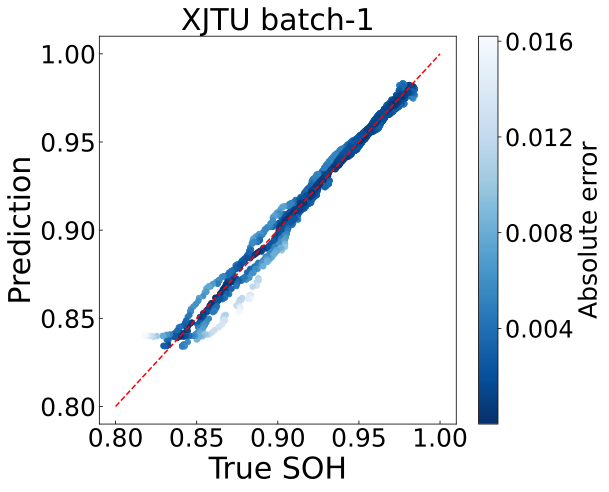

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
# 示例数据
true_soh=np.concatenate((test_results[0][0],test_results[1][0],test_results[2][0]),axis=0)/2
# true_soh = test_results[1][0]
prediction=np.concatenate((test_results[0][1].reshape(-1),test_results[1][1].reshape(-1),test_results[2][1].reshape(-1)),axis=0)/2
# prediction = test_results[1][1].reshape(-1)

print(true_soh)
print(prediction)
def filter_arrays(arr1, arr2, threshold=0.8):
    """
    删除第一个数组中小于阈值的部分，并根据第一个数组删除的索引，删除第二个数组的对应值。

    参数:
    arr1 (np.array): 第一个数组。
    arr2 (np.array): 第二个数组。
    threshold (float): 阈值，默认为0.8。

    返回:
    filtered_arr1 (np.array): 过滤后的第一个数组。
    filtered_arr2 (np.array): 过滤后的第二个数组。
    """
    # 检查两个数组长度是否相同
    if len(arr1) != len(arr2):
        raise ValueError("两个数组的长度必须相同！")

    # 找到第一个数组中大于等于阈值的索引
    valid_indices = arr1 >= threshold

    # 根据索引过滤两个数组
    filtered_arr1 = arr1[valid_indices]
    filtered_arr2 = arr2[valid_indices]

    return filtered_arr1, filtered_arr2
true_soh,prediction=filter_arrays(true_soh,prediction)
# print(true_soh)
# print(prediction.reshape(-1))
distance = np.abs(true_soh - prediction) / np.sqrt(2)
# print(distance)
# 创建散点图
plt.figure(figsize=(8, 7))
scatter = plt.scatter(true_soh, prediction, c=distance, cmap='Blues_r', alpha=1,s=30)

# 添加中间红线
plt.plot([0.80, 1.00], [0.80, 1.00], color='red', linestyle='--')
plt.xticks(np.arange(0.80, 1.01, 0.05),fontsize=25)
plt.yticks(np.arange(0.80, 1.01, 0.05),fontsize=25)
# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute error',fontsize=25)
cbar.ax.tick_params(labelsize=24)
# 设置最大刻度数为5
cbar.locator = MaxNLocator(nbins=5)
# 实际显示刻度数 = nbins + 1
cbar.update_ticks()
# 将刻度线画在坐标轴内部
plt.tick_params(axis='both', direction='in')

# 添加标签和标题
plt.xlabel('True SOH',fontsize=30)
plt.ylabel('Prediction',fontsize=30)
plt.title('XJTU batch-1',fontsize=30)
# plt.legend()

# 显示图表
plt.show()

# MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size=11, output_size=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, output_size))
    def forward(self, x):
        return self.net(x)
def train_mlp(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = MLP()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<10e-6 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [10]:
tests_mlp=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_mlp(seed=i,device=device)
    tests_mlp.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.5914, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.4383, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0526, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0181, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0050, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0068, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0069, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0071, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [11]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.029584587212555406, 0.02332230519122444, 0.041324093386799515, 0.059068150766248, 0.032865553494468, 0.06146940597401964, 0.06032905026651662, 0.09040401280164947, 0.06895617622651387, 0.054666376804764015, 0.03517362879315697, 0.06969642005829452, 0.01921529983828216, 0.03336773521902409, 0.02890600001439026]
MAE: [0.023705543042574957, 0.018963186401831335, 0.02858150001448026, 0.05137539048253202, 0.026972928942836295, 0.053762190111640344, 0.05435247996250413, 0.08020198412267875, 0.06070052310398649, 0.04537348003154191, 0.02977951199201578, 0.05680043089795274, 0.014969369341041955, 0.024766315155609488, 0.020871437873970087]
MAPE: [0.012967096321801371, 0.010246284629342326, 0.01589099916887352, 0.028045151743352877, 0.014268652153184633, 0.029523600204835777, 0.029388571390083794, 0.04381817674279214, 0.03323442995177229, 0.024814706555170808, 0.015849533257456173, 0.03126595258225768, 0.00811605389964186, 0.013618804418643816, 0.01154785126418649]
R2: [0.8768051619226

In [37]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests_mlp)):
#     for j in range(len(tests_mlp[0])):
#         real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

RMSE: [0.047205495197372674]
MAE: [0.03864157]


In [12]:
class ConvNet(nn.Module):
    def __init__(self, n_input=11):
        super(ConvNet, self).__init__()
        # 输入重塑为 (batch, 1, n_input)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * (n_input // 2), 64)  # 根据池化后的维度调整
        self.fc2 = nn.Sequential(nn.Linear(64 , 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 1),)
    
    def forward(self, x):
        # 输入 x 的形状: (batch, n_input)
        x = x.unsqueeze(1)  # 重塑为 (batch, 1, n_input)
        x = self.conv1(x)   # 卷积后形状: (batch, 32, n_input)
        x = self.relu(x)
        x = self.pool(x)    # 池化后形状: (batch, 32, n_input // 2)
        x = x.view(x.size(0), -1)  # 展平为 (batch, 32 * (n_input // 2))
        x = self.fc1(x)     # 全连接层
        x = self.relu(x)
        x = self.fc2(x)     # 输出形状: (batch, 1)
        return x
def train_conv(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = ConvNet()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<5e-5 and epoch>=10)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
tests_cnn=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_conv(seed=i,device=device)
    tests_cnn.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.3934, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.2041, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0246, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0249, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0250, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0123, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0088, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0266, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0340, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0068, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [14]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.05152359825536148, 0.03226020423531887, 0.06604890794838122, 0.026795924974970745, 0.025164601153835134, 0.04463018517898583, 0.04328698121531014, 0.03579730725450122, 0.0562605767444814, 0.06860360001299766, 0.0904955229515584, 0.05698245284178754, 0.0381372341451459, 0.055679463506226386, 0.038157335269838076]
MAE: [0.03825252194193773, 0.027280236081025467, 0.05437619764302053, 0.021353169115556344, 0.02033879759828401, 0.03334227389381049, 0.033211958063400146, 0.029848100818155393, 0.04650753952208018, 0.05784004223088783, 0.07314239503766191, 0.04512958833798262, 0.032303234031260945, 0.042164363367929225, 0.029575352584423658]
MAPE: [0.021143871216840558, 0.014764990278443574, 0.03013767488555876, 0.01155974348630632, 0.010943078041260448, 0.018313426149079732, 0.018303483601916914, 0.016094651942879425, 0.025700858953628933, 0.031513937263275685, 0.04020008108637508, 0.024476191335723253, 0.017392118574313428, 0.02325078328325215, 0.016199015336771642]
R2: [0.626342371

In [15]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size=11, hidden_size=60, num_layers=6, output_size=1):
        """
        LSTM网络初始化
        :param input_size: 输入特征的维度 (n)
        :param hidden_size: 隐藏层的维度
        :param num_layers: LSTM的层数
        :param output_size: 输出的维度 (1)
        """
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 定义全连接层，将LSTM的输出映射到输出维度
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        前向传播
        :param x: 输入数据，形状为 (batch_size, input_size)
        :return: 输出数据，形状为 (batch_size, output_size)
        """
        # 添加序列维度 (sequence_length=1)
        x = x.unsqueeze(1)  # 形状变为 (batch_size, 1, input_size)

        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))  # out的形状为 (batch_size, 1, hidden_size)

        # 只取最后一个时间步的输出
        out = out[:, -1, :]  # 形状为 (batch_size, hidden_size)

        # 全连接层映射到输出维度
        out = self.fc(out)  # 形状为 (batch_size, output_size)

        return out

def train_lstm(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = LSTMNetwork()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<5e-5 and epoch>=10)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
tests_lstm=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_lstm(seed=i,device=device)
    tests_lstm.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.5487, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0446, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0108, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0090, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0047, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0048, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0026, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0017, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0013, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [17]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests_lstm)):
    for j in range(len(tests_lstm[0])):
        real,pred=tests_lstm[i][j][0],tests_lstm[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.02086413297642301, 0.02346453089363756, 0.02246143189334145, 0.024505852890778786, 0.026457731687140162, 0.0233521632602128, 0.015993486208776775, 0.018156514497691126, 0.01701801703162704, 0.021793693752571456, 0.024665639323895316, 0.023179778946037375, 0.0304238738525889, 0.032786205148636643, 0.028847013538276935]
MAE: [0.011794315201767424, 0.01313578599850034, 0.015183585880564997, 0.01670352950145477, 0.016975549240982588, 0.01700954293880332, 0.008961374821129105, 0.009470391190097354, 0.01094457312343882, 0.012541620157624, 0.014659769689175562, 0.016237413244182555, 0.015151139763538745, 0.015228557905770082, 0.016162654944828575]
MAPE: [0.006317529915887639, 0.007079722235143755, 0.008306787507165759, 0.008971922926719599, 0.009106167991699984, 0.009192339879782463, 0.004869345683249523, 0.005149339743087749, 0.006038679152424246, 0.006726668358852547, 0.007906969691952292, 0.008898724601822325, 0.00808739883984335, 0.008128468265908016, 0.008709692226437752]
R2: [0

In [40]:
rmse_all=0
mae_all=0
num=0
for i in range(len(tests_cnn)):
    for j in range(len(tests_cnn[0])):
        real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1]
        rmse=evaluation(real,pred)
        rmse_all+=(rmse)
        mae_all+=calculate_mae(real,pred)
        num+=1
print('RMSE:',[rmse_all/num])
print('MAE:',mae_all/num)

RMSE: [0.04988660577758232]
MAE: [0.03999891]
